# Importing the data

First, we will start by importing a `pandas.DataFrame` of the scraped data. For the purpose of this example, the data has already been scraped and stored in `donald_trump.csv`. 

instascrape has been designed in such a way to be highly compatible with `pandas` and thus tabular data is standard usage for manipulating scraped data.  

In [1]:
import ast 

import pandas as pd 

df = pd.read_csv(
    "donald_trump.csv", 
    converters={
        "hashtags":ast.literal_eval, 
        "tagged_users":ast.literal_eval,
    },
    parse_dates=["upload_date"]
)

# Preprocessing the data

For the next few sections, I'm going to be working towards fitting a polynomial regresssion that will allow us to model upload datetime vs. likes per post. 
 
Now that we have our data in a `pandas.DataFrame`, let's prepare it to be fitted with a `scikit.linear_model.LinearRegression`. We will start by using `sklearn.preprocessing.StandardScaler` to scale our data into an appropriate range. 

In [2]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()      
sc_y = StandardScaler()

# Convert a 1D numpy array into a 2D column-like array. 
def two_dimensionalize(arr): return arr.reshape((len(arr), 1))

# StandardScaler.fit_transform expects a 2D-array. 
x_dt = df['timestamp'].to_numpy()
x_dt = two_dimensionalize(x_dt)
y_dt = df['likes'].to_numpy()
y_dt = two_dimensionalize(y_dt)

# Feature scaling to get data on same scale.
x_transform = sc_x.fit_transform(x_dt)
y_transform = sc_y.fit_transform(y_dt)

Now that our data is scaled appropriately, we are going to create a new feature matrix with data prepared for a polynomial regression. To do so, we will transform our data with `sklearn.preprocessing.PolynomialFeatures`

In [3]:
from sklearn.preprocessing import PolynomialFeatures

#Further scaling for IV.
polyreg = PolynomialFeatures(degree=6)
x_poly = polyreg.fit_transform(x_transform)

# Fitting the polynomial regressor

Now that our data has been preprocessed and we have an appropriate feature matrix for fitting a polynomial regression, we will fit our data and get a set of dependant variables predicted by the regressor. 

In this case, we will use these values to plot a curve fit to show underlying trends in a scatter plot. 

In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np

#Create and fit polynomial regression. 
regressor = LinearRegression()
regressor.fit(x_poly, y_transform)

#Calculate predictions from the model for every independant variable data point.  
y_predict = np.array([regressor.predict([val]) for val in x_poly])
y_predict = two_dimensionalize(y_predict)
y_final = sc_y.inverse_transform(y_predict)
y_final = y_final.flatten()

# Visualizing our data

Now with our data and polynomial regression, we can create a scatter plot to visualize user engagement over the last few months.

In [5]:
import datetime

import matplotlib.pyplot as plt
import matplotlib

# Create plot and style. 
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16,4))

# Draw scatter plot.
upload_date = df["upload_date"].to_numpy()
likes = df["likes"].to_numpy()
ax.scatter(upload_date, likes, label="Post")

# Draw polynomial regression.
ax.plot(upload_date, y_final, label='Fit', color="blue")

# Draw Election Day vertical line. 
election_date = datetime.date(2020, 11,3)
ax.axvline(election_date, linestyle='--', label="Election Day", color="black")

# Set plot x-bounds. 
left_xlim=df["upload_date"].min()-datetime.timedelta(days=3)
right_xlim=df["upload_date"].max()+datetime.timedelta(days=3)
ax.set_xlim(left=left_xlim, right=right_xlim)

# Draw labels on plot. 
ax.set_title("@realdonaldtrump Instagram Likes per Post")
ax.set_xlabel("Date")
ax.set_ylabel("Likes")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Format and draw plot legend.
handles,labels = ax.get_legend_handles_labels()
handles = [handles[2], handles[0], handles[1]]
labels = [labels[2], labels[0], labels[1]]
ax.legend(handles,labels, loc=1);

# Comparing likes and comments per post 

Another interesting visualization we can examine compares the amount of likes and comments each post gets. To do so, we will draw a stacked bar plot with a logarithmically scaled y-axis. 

The reason I chose a logarithmic scale is to bring the comments into better visibility (otherwise, the amount of comments would barely be visible).

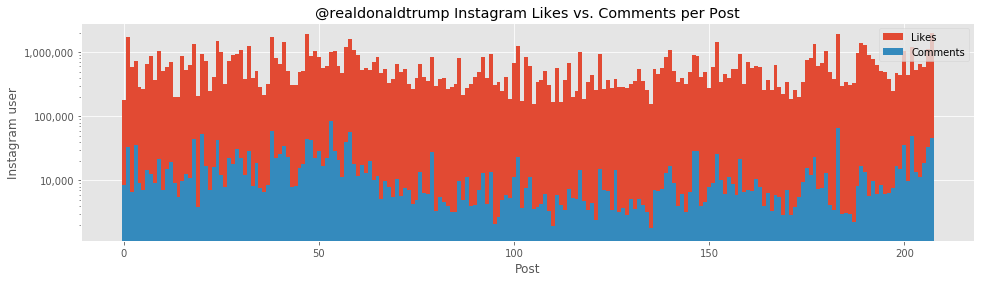

In [6]:
# Create the figure
fig, ax = plt.subplots(figsize=(16,4), facecolor="w")
ax.set_yscale('log')

# Draw the plots 
posts = [i for i in range(len(df))]
likes = df['likes'].to_numpy()
comments = df["comments"].to_numpy()
ax.bar(posts, likes, label="Likes", width=1)
ax.bar(posts, comments, label="Comments", width=1)

# Draw the labels 
ax.set_title("@realdonaldtrump Instagram Likes vs. Comments per Post")
ax.set_xlabel("Post")
ax.set_ylabel("Instagram user")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend()

# Analyzing tagged locations 

Now let's take a look at all the locations that Donald Trump has tagged in his photos. Since we don't care about posts where he didn't tag a location, we'll just drop those so we can focus on posts where he did tag a location. 

Additionally, we're going to count how many rows each location appeared in as this will give us a quick idea of how many times the location was tagged. 

In [7]:
locations_df = df[df["location"].notna()]
locations_count = locations_df["location"].value_counts()
locations_count

Information icon.                               113
The White House                                  22
Michigan                                          4
Pennsylvania                                      4
Johnstown, Pennsylvania                           3
Hickory, North Carolina                           1
Scranton, Pennsylvania                            1
Tucson, Arizona                                   1
The Villages, Florida                             1
Erie, Pennsylvania                                1
Florida                                           1
Texas                                             1
Lumberton, North Carolina                         1
North Carolina                                    1
Janesville, Wisconsin                             1
Arizona                                           1
Greenville, North Carolina                        1
Goodyear, Arizona                                 1
Carson City, Nevada                               1
Lititz, Penn

Text(0.5, 1.0, "Donald Trump's Tagged Locations")

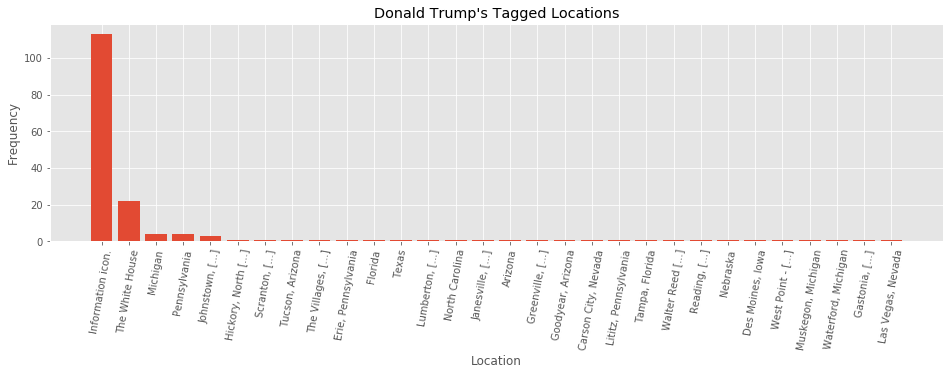

In [8]:
from textwrap import shorten

# Create the figure 
fig, ax = plt.subplots(figsize=(16,4), facecolor='w')

# Draw the bar plot
locations = locations_count.index.to_list()
formatted_locations = [shorten(loc, width=20) for loc in locations]
frequency = locations_count.to_list()
ax.bar(formatted_locations, frequency)

# Draw the labels 
ax.set_xlabel("Location")
plt.xticks(rotation=80)
ax.set_ylabel("Frequency")
ax.set_title("Donald Trump's Tagged Locations")

In [9]:
percent_location = len(locations_df)/len(df)
print(f"Donald Trump tagged a location in {percent_location:.2%} of his recent posts.")

Donald Trump tagged a location in 82.21% of his recent posts.


# Analyzing other tagged accounts

Now let's analyze how many times Donald Trump tagged someone else in one of his posts.

Since each row's tagged users value is a `list`, we will explode the `list`'s and count the amount of occurrences of each tagged person.

In [10]:
tagged_df = df[df["tagged_users"].str.len() != 0]
tagged_df["tagged_users"].explode().value_counts()

ivankatrump    1
Name: tagged_users, dtype: int64

In [11]:
percent_tagged = len(tagged_df)/len(df)
print(f"Donald Trump tagged another account in {percent_tagged:.2%} of his recent posts.")

Donald Trump tagged another account in 0.48% of his recent posts.


If you're interested in seeing the post, let's get the shortcode for this single post so you can navigate to the URL yourself and confirm Ivanka Trump is in it. 

In [12]:
shortcode = tagged_df.iloc[0]['shortcode']
print(f"https://www.instagram.com/p/{shortcode}/")

https://www.instagram.com/p/CG-ahVPMUyw/


# Views per Video 

Let's check how many views Trump has gotten on his recently posted videos. 

In [13]:
videos_df = df[df["is_video"]]
videos_df["video_view_count"]

0      1067351.0
3      4856621.0
4      1362498.0
5       980660.0
13     1134196.0
         ...    
200    4571207.0
201    1665675.0
202    5260684.0
205    2490852.0
206    4895397.0
Name: video_view_count, Length: 88, dtype: float64

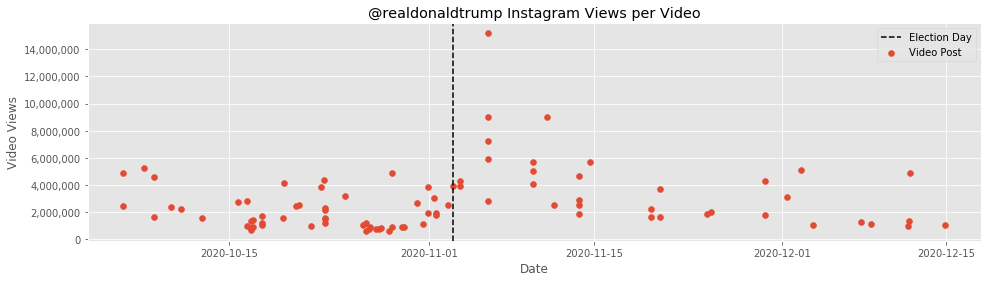

In [14]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(16,4), facecolor='w')

# Draw scatter plot and vertical line 
upload_date = videos_df['upload_date'].to_numpy()
view_count = videos_df['video_view_count'].to_numpy()
ax.scatter(upload_date, view_count, label="Video Post")
ax.axvline(election_date, linestyle='--', label="Election Day", color="black")

# Set plot x-bounds. 
left_xlim=videos_df["upload_date"].min()-datetime.timedelta(days=3)
right_xlim=videos_df["upload_date"].max()+datetime.timedelta(days=3)
ax.set_xlim(left=left_xlim, right=right_xlim)

# Draw labels onto plot 
ax.set_title("@realdonaldtrump Instagram Views per Video")
ax.set_xlabel("Date")
ax.set_ylabel("Video Views")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend();

# Views and Likes per Video 

Similar to the likes and comments per post, we're going to build a stacked bar plot that showcases likes vs. views per video post. 

Once again, we'll be using a logarithmically scaled y-axis since there are much less likes than views. 

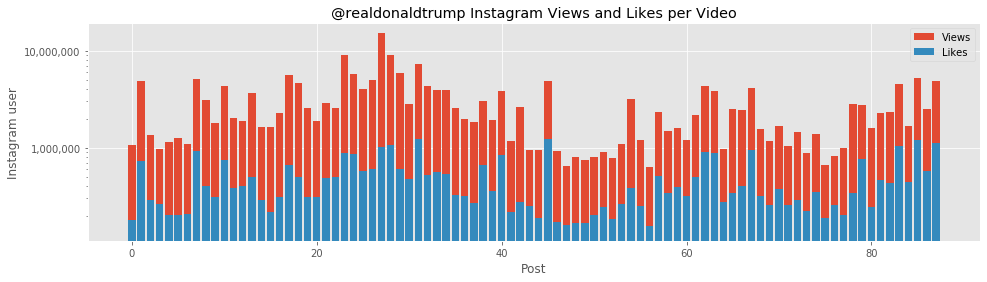

In [15]:
# Create figure and set logarithmic y-axis
fig, ax = plt.subplots(figsize=(16,4), facecolor='w')
ax.set_yscale('log')

# Draw bar plots 
posts = [i for i in range(len(videos_df))]
view_count = videos_df['video_view_count'].to_numpy()
likes = videos_df["likes"].to_numpy()
ax.bar(posts, view_count, label="Views")
ax.bar(posts, likes, label="Likes")

# Draw labels 
ax.set_title("@realdonaldtrump Instagram Views and Likes per Video")
ax.set_xlabel("Post")
ax.set_ylabel("Instagram user")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend();

# Analyzing Trump's hashtags 

As a final exercise, let's visualize what hashtags Donald Trump uses in his posts.

Similar to tagged users, hashtag values are also represented as a `list` of all hashtags. Hence, we will be exploding the list and counting the occurences of each value to see which hashtag is used the most. 

In [16]:
hashtags_df = df[df["hashtags"].str.len() != 0]
hashtags_count = hashtags_df["hashtags"].explode().value_counts()
hashtags_count

Repost              28
MAGA                19
VOTE                 9
KeepAmericaGreat     2
thehenningsens       1
Michigan             1
WeDeserveToKnow      1
president            1
charlotte            1
whyIfarm             1
northcarolina        1
HappyHalloween       1
donaldtrump          1
Georgia              1
Name: hashtags, dtype: int64

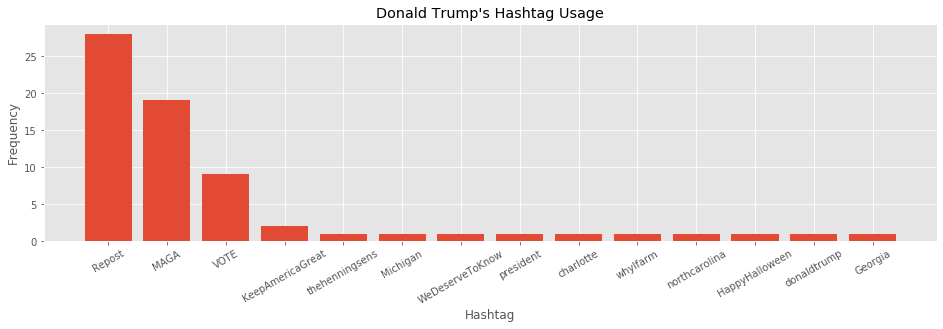

In [17]:
# Create the figure. 
fig, ax = plt.subplots(figsize=(16,4), facecolor="w")

# Draw the bar plot. 
hashtags = hashtags_count.index.to_list()
frequency = hashtags_count.to_list()
ax.bar(hashtags, frequency)

# Draw the labels. 
ax.set_xlabel("Hashtag")
plt.xticks(rotation=30)
ax.set_ylabel("Frequency")
ax.set_title("Donald Trump's Hashtag Usage");